# Structured Kernel Interpollation (SKI/KISS-QEP)

## Overview

SKI (or KISS-QEP) is a great way to scale a QEP up to very large datasets (100,000+ data points).
Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

SKI is asymptotically very fast (nearly linear), very precise (error decays cubically), and easy to use in QPyTorch!
As you will see in this tutorial, it's really easy to apply SKI to an existing model. All you have to do is wrap your kernel module with a `GridInterpolationKernel`.

In [1]:
import math
import torch
import qpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

## KISS-QEP for 1D Data

### Set up training data

We'll learn a simple sinusoid, but with lots of training data points. At 1000 points, this is where scalable methods start to become useful.

In [2]:
train_x = torch.linspace(0, 1, 2000)
train_y = torch.sin(train_x * (4 * math.pi) + torch.randn(train_x.size()) * 0.2)

### Set up the model

The model should be somewhat similar to the `ExactQEP` model in the [simple regression example](../01_Exact_QEPs/Simple_QEP_Regression.ipynb).

The only difference: we're wrapping our kernel module in a `GridInterpolationKernel`. This signals to QPyTorch that you want to approximate this kernel matrix with SKI.

SKI has only one hyperparameter that you need to worry about: the grid size. For 1D functions, a good starting place is to use as many grid points as training points. (Don't worry - the grid points are really cheap to use!). You can use the `qpytorch.utils.grid.choose_grid_size` helper to get a good starting point.

If you want, you can also explicitly determine the grid bounds of the SKI approximation using the `grid_bounds` argument. However, it's easier if you don't use this argument - then QPyTorch automatically chooses the best bounds for you.

In [3]:
POWER = 1.0
class QEPRegressionModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super(QEPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        
        # SKI requires a grid size hyperparameter. This util can help with that. Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = qpytorch.utils.grid.choose_grid_size(train_x,1.0)
        
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = qpytorch.kernels.ScaleKernel(
            qpytorch.kernels.GridInterpolationKernel(
                qpytorch.kernels.RBFKernel(), grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

    
likelihood = qpytorch.likelihoods.QExponentialLikelihood(power=torch.tensor(POWER))
model = QEPRegressionModel(train_x, train_y, likelihood)

### Train the model hyperparameters

Even with 1000 points, this model still trains fast! SKI scales (essentially) linearly with data - whereas standard QEP inference scales quadratically (in QPyTorch.)

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 30


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes QExponentialLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

/Users/shiweilan/miniconda/envs/qpytorch/lib/python3.10/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/Users/shiweilan/miniconda/envs/qpytorch/lib/python3.10/site-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  res = cls(index_tensor, value_tensor, interp_size)


### Make predictions

SKI is especially well-suited for predictions. It can comnpute predictive means in constant time, and with LOVE enabled (see [this notebook](./Simple_QEP_Regression_With_LOVE_Fast_Variances_and_Sampling.ipynb)), predictive variances are also constant time.

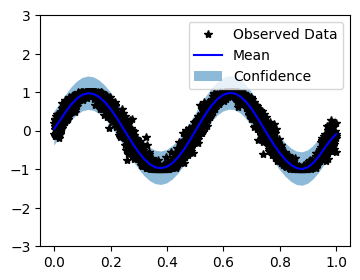

In [5]:
# Put model & likelihood into eval mode
model.eval()
likelihood.eval()

# Initalize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))

# The qpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), qpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    prediction = likelihood(model(test_x))
    mean = prediction.mean
    # Get lower and upper predictive bounds
    lower, upper = prediction.confidence_region()

# Plot the training data as black stars
def ax_plot():
    if smoke_test: return  # this is for running the notebook in our testing framework
    
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.detach().numpy(), mean.detach().numpy(), 'b')
    # Plot confidence bounds as lightly shaded region
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

ax_plot()

## KISS-QEP for 2D-4D Data

For 2-4D functions, SKI (or KISS-QEP) can work very well out-of-the-box on larger datasets (100,000+ data points).
Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

One thing to watch out for with multidimensional SKI - you can't use as fine-grain of a grid. If you have a high dimensional problem, you may want to try one of the other scalable regression methods.

### Set up train data

Here we're learning a simple sin function - but in 2 dimensions

In [6]:
# We make an nxn grid of training points spaced every 1/(n-1) on [0,1]x[0,1]
n = 40
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
# True function is sin( 2*pi*(x0+x1))
train_y = torch.sin((train_x[:, 0] + train_x[:, 1]) * (2 * math.pi)) + torch.randn_like(train_x[:, 0]).mul(0.01)

### The model

As with the 1D case, applying SKI to a multidimensional kernel is as simple as wrapping that kernel with a `GridInterpolationKernel`. You'll want to be sure to set `num_dims` though!

SKI has only one hyperparameter that you need to worry about: the grid size. For 1D functions, a good starting place is to use as many grid points as training points. (Don't worry - the grid points are really cheap to use!). You can use the `qpytorch.utils.grid.choose_grid_size` helper to get a good starting point.

If you want, you can also explicitly determine the grid bounds of the SKI approximation using the `grid_bounds` argument. However, it's easier if you don't use this argument - then QPyTorch automatically chooses the best bounds for you.

In [8]:
class QEPRegressionModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super(QEPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = qpytorch.utils.grid.choose_grid_size(train_x)
        
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = qpytorch.kernels.ScaleKernel(
            qpytorch.kernels.GridInterpolationKernel(
                qpytorch.kernels.RBFKernel(), grid_size=grid_size, num_dims=2
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

    
likelihood = qpytorch.likelihoods.QExponentialLikelihood(power=torch.tensor(POWER))
model = QEPRegressionModel(train_x, train_y, likelihood)

### Train the model hyperparameters

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes QExponentialLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

%time train()

CPU times: user 12 s, sys: 410 ms, total: 12.4 s
Wall time: 2.09 s


### Make predictions with the model

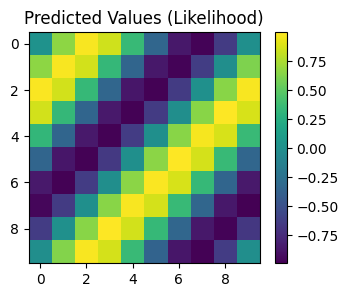

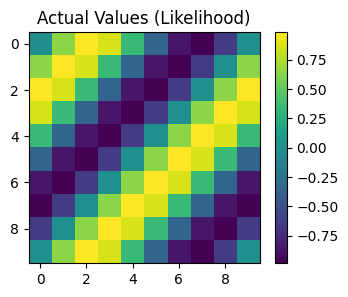

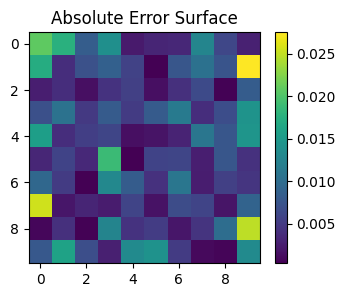

In [10]:
# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Generate nxn grid of test points spaced on a grid of size 1/(n-1) in [0,1]x[0,1]
n = 10
test_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n):
    for j in range(n):
        test_x[i * n + j][0] = float(i) / (n-1)
        test_x[i * n + j][1] = float(j) / (n-1)

with torch.no_grad(), qpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean.view(n, n)

# Calc abosolute error
test_y_actual = torch.sin(((test_x[:, 0] + test_x[:, 1]) * (2 * math.pi))).view(n, n)
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    if smoke_test: return  # this is for running the notebook in our testing framework
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

# Plot the true values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

# Plot the absolute errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')

## Scaling to more dimensions

If your data is high dimensional, try one of the following methods:

1. SKIP - or [Scalable Kernel Interpolation for Products](./Scalable_Kernel_Interpolation_for_Products_CUDA.ipynb)
2. KISS-QEP with [Deep Kernel Learning](../06_PyTorch_NN_Integration_DKL/KISSQEP_Deep_Kernel_Regression_CUDA.ipynb)